# CE-40717: Machine Learning

## HW5-Support Vector Machine

### Please fill this part


1.   Full Name: Pouya Khani
2.   Student Number: 99210283


*You are just allowded to change those parts that start with "TO DO". Please do not change other parts.*

*It is highly recommended to read each codeline carefully and try to understand what it exactly does. Best of luck and have fun!*

In [ ]:
# You are not allowed to import other packages.
import numpy as np
import pandas as pd
 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC

import cvxopt

In [ ]:
import warnings
warnings.filterwarnings("ignore")

#### About the Data:
Heart diseases, also known as [Cardiovascular diseases (CVDs)](https://en.wikipedia.org/wiki/Cardiovascular_disease), are the first cause of death worldwide, taking an estimated 17.9 million lives each year which is about 32% of all deaths all over the world. 

In the present HomeWork, we are going to implement Support Vector Machines (SVM) algorithm that determines which patient is in danger and which is not.

For this perpose, `Heart_Disease_Dataset.csv` file can be used that is attached to the HomeWork folder. Use `Dataset_Description.pdf` for more detail.


In [ ]:
df = pd.read_csv("./Heart_Disease_Dataset.csv") 

### Pre-Processing - (15pts)

#### Exploratory Data Analysis (EDA):
In statistics, exploratory data analysis is an approach to analyze datasets to summarize their main characteristics, often using statistical graphics and other data visualization methods.

This is a general approach that should be applied when you encounter a dataset.

shape of dataset is:  (1190, 12)


 numbers of missing values per feature is:
 age                    0
sex                    0
chest pain type        0
resting bp s           0
cholesterol            0
fasting blood sugar    0
resting ecg            0
max heart rate         0
exercise angina        0
oldpeak                0
ST slope               0
target                 0
dtype: int64

Thus this dataset has not missing values


Distribution of classes is:
1    629
0    561
Name: target, dtype: int64

So ballanced is: True



                --------------------- Plots --------------------------


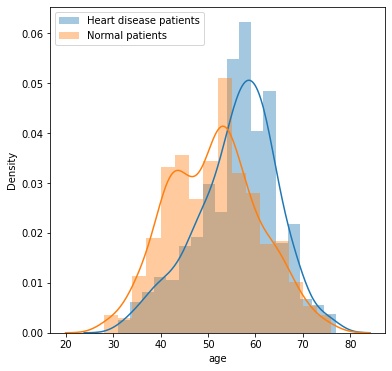

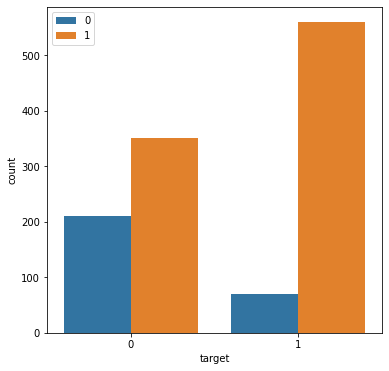

In [ ]:
shape = df.shape
print("shape of dataset is: " , shape)

missings = df.isnull().sum()
print(f"\n\n numbers of missing values per feature is:\n {missings}")
print("\nThus this dataset has not missing values\n\n")

print("Distribution of classes is:")
print(df['target'].value_counts())
print("\nSo ballanced is: True\n\n\n")

plt.figure(figsize=(6, 6))
sns.distplot(df[df['target'] == 1]['age'], label= "Heart disease patients")
sns.distplot(df[df['target'] == 0]['age'], label= "Normal patients")
plt.legend()

# 1 = male; 0 = female
plt.figure(figsize=(6, 6))
sns.countplot(df['target'], hue = df['sex'])
plt.legend()
print("                --------------------- Plots --------------------------")

#### Question 1: What do you conclude from the plots?
#### Answer: We conclude that heart disease occured more around 60-years-old and older patients and below this age, heart disease less occured. and We find that men are more likely to get sick than women, and among of all patients, men are more likely to get heart disease. 

#### Outlier Detection & Removal:
We will filter ouliers using Z-test.

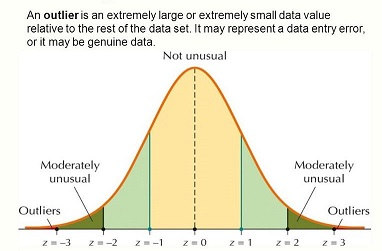

Z-test formula:
\begin{equation*}
    Z = \bigg|\frac {x - mu} {std}\bigg|
\end{equation*}

In [ ]:
columns = ["age","resting bps","cholesterol","max heart rate"]
threshold = 3
df['zscore'] = ( df['age'] - df['age'].mean() ) / df['age'].std()
df = df[(df['zscore'] >-3) & (df['zscore'] <3)]
df['zscore']=(df['resting bp s']-df['resting bp s'].mean())/df['resting bp s'].std()
df = df[(df['zscore'] >-3) & (df['zscore'] <3)]
df['zscore']=(df['cholesterol']-df['cholesterol'].mean())/df['cholesterol'].std()
df = df[(df['zscore'] >-3) & (df['zscore'] <3)]
df['zscore']=(df['max heart rate']-df['max heart rate'].mean())/df['max heart rate'].std()
df = df[(df['zscore'] >-3) & (df['zscore'] <3)]
df = df.drop('zscore',axis=1)
df.shape

(1173, 12)

#### Feature Engineering:
Sometimes the collected data are raw; they are either incompatible with your model or hinders its performance. That’s when feature engineering comes to rescue. It encompasses preprocessing techniques to compile a dataset by extracting features from raw data.


In [ ]:
df['age'] = (df['age'] - df['age'].min())/(df['age'].max()-df['age'].min())
df['resting bp s'] = (df['resting bp s'] - df['resting bp s'].min())/(df['resting bp s'].max()-df['resting bp s'].min())
df['cholesterol'] = (df['cholesterol'] - df['cholesterol'].min())/(df['cholesterol'].max()-df['cholesterol'].min())
df['max heart rate'] = (df['max heart rate'] - df['max heart rate'].min())/(df['max heart rate'].max()-df['max heart rate'].min())
df['oldpeak'] = (df['oldpeak'] - df['oldpeak'].min())/(df['oldpeak'].max()-df['oldpeak'].min())
df['max heart rate'] = (df['max heart rate'] - df['max heart rate'].min())/(df['max heart rate'].max()-df['max heart rate'].min())
df.head(10)

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,0.244898,1,2,0.571429,0.588595,0,0,0.777778,0,0.295455,1,0
1,0.428571,0,3,0.761905,0.366599,0,0,0.659259,0,0.409091,2,1
2,0.183673,1,2,0.476190,0.576375,0,1,0.229630,0,0.295455,1,0
3,0.408163,0,4,0.552381,0.435845,0,0,0.303704,1,0.465909,2,1
4,0.530612,1,3,0.666667,0.397149,0,0,0.407407,0,0.295455,1,0
5,0.224490,1,3,0.380952,0.690428,0,0,0.762963,0,0.295455,1,0
6,0.346939,0,2,0.476190,0.482688,0,0,0.762963,0,0.295455,1,0
7,0.530612,1,2,0.285714,0.423625,0,0,0.555556,0,0.295455,1,0
8,0.183673,1,4,0.571429,0.421589,0,0,0.466667,1,0.465909,2,1
9,0.408163,0,2,0.380952,0.578411,0,0,0.392593,0,0.295455,1,0


### SVM - (25pts)

#### spliting data

In [ ]:
df.target.replace(0 , -1 , inplace = True) 

df = df.to_numpy()

train = df[:int(len(df) * 0.7)]
test = df[int(len(df) * 0.7):]
 
X_train = train[: , :-1]
y_train = train[: , -1]

X_test = test[: , :-1]
y_test = test[: , -1]

print("Train: ", X_train.shape ,y_train.shape)
print("Test: " ,X_test.shape ,y_test.shape)


Train:  (821, 11) (821,)
Test:  (352, 11) (352,)


In [ ]:
def compute(y_true, y_pred):
 tp=0
 tn=0
 fn=0
 fp=0
 for i in range(len(y_true)):
  if (y_true[i] == 1) & (y_pred[i] == 1):
   tp = tp+1
  elif (y_true[i] == -1) & (y_pred[i] == -1):
   tn = tn+1
  elif (y_true[i] == 1) & (y_pred[i] == -1):
   fn = fn+1
  elif (y_true[i] == -1) & (y_pred[i] == 1):
   fp = fp+1
 return tp, tn, fp, fn

#### SVM Using sklearn:
Use the standard libarary SVM classifier (SVC) on the training data, and then test the classifier on the test data. You will need to call SVM with 3 kernels: (1) Linear, (2) Polynomial and (3) RBF. You can change C to achive better results. For "RBF" find "gamma" witch takes 90% accuracy, at least. For polynomial kernel you are allowed to change "degree" to find best results.

For each kernel, reportting the followings is required:
Accuracy, Precision, Recall, F1score.

In [ ]:
def classification_report(y_true, y_pred):
    tp,tn,fp,fn = compute(y_true,y_pred)
    Accuracy = ((tp + tn) * 100) / float( tp + tn + fn + fp)
    Precision = (tp  * 100)/ float( tp + fp)
    Recall = (tp  * 100)/ float( tp + fn)
    F1score = (2*Precision*Recall)/ (Precision + Recall)
    return Accuracy, Precision, Recall, F1score

In [ ]:
model = SVC(kernel='linear')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc,pre,rec,f1 = classification_report(y_test, y_pred)
print(f"results of sklearn svm linear kernel:\n acc:{acc},pre:{pre},rec:{rec},f1:{f1}\n")



model = SVC(kernel='poly',degree=2)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc,pre,rec,f1 = classification_report(y_test, y_pred)
print(f"results of sklearn svm polynominal kernel:\n acc:{acc},pre:{pre},rec:{rec},f1:{f1}\n")



model = SVC(kernel='rbf',gamma=12)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc,pre,rec,f1 = classification_report(y_test, y_pred)
print(f"results of sklearn svm RBF kernel:\n acc:{acc},pre:{pre},rec:{rec},f1:{f1}\n")

results of sklearn svm linear kernel:
 acc:78.69318181818181,pre:77.56410256410257,rec:75.15527950310559,f1:76.34069400630915

results of sklearn svm polynominal kernel:
 acc:78.4090909090909,pre:79.3103448275862,rec:71.42857142857143,f1:75.16339869281046

results of sklearn svm RBF kernel:
 acc:90.05681818181819,pre:86.20689655172414,rec:93.16770186335404,f1:89.55223880597015



#### SVM:
Now that you know how the standard library SVM works on the dataset, attempt to implement your own version of SVM. Implement SVM using Quadratic Programming(QP) approach. Remember that SVM objective fuction with QP is:

\begin{equation*}
    min_{\alpha}\quad\frac{1}{2}\alpha^T\,Q\,\alpha-1^T\,\alpha\\
    s.t.\qquad y^T\,\alpha=0,\,\alpha\ge0
\end{equation*}

where:
\begin{equation*}
    Q_{i,j}=y_i\,y_j\,\langle x_i\,,\,x_j\rangle
\end{equation*}

and:
\begin{equation*}
    \text{if}\;(\alpha_n>0)\;\text{then}\;x_n\;\text{is a  support vector}
\end{equation*}

For this perpose, complete the following code. You are allowed to use "cvxopt" package. It's an optimization package for Quadratic Programming. Below is the user's guide for the QP from CVXOPT:

[Quadratic Programming](https://cvxopt.org/userguide/coneprog.html#quadratic-programming)

In [ ]:
cvxopt.solvers.options["show_progress"] = False
def linear_kernel(x,y):
    return np.dot(x, y)

def polynomial_kernel(x, y, degree=2):
    return np.power(np.dot(x,y), degree)

def rbf_kernel(x,y,gamma=12):
    return np.exp(-gamma*(np.linalg.norm(x-y)**2))

class SVM(object):

    def __init__(self, kernel=linear_kernel, C=None):
        self.kernel = kernel
        self.C = C
        if self.C is not None: self.C = float(self.C)

    def fit(self, X, y):
        n_samples, n_features = X.shape

        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])

        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1,n_samples))
        b = cvxopt.matrix(0.0)

        if self.C is None:
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        alpha = np.ravel(solution['x'])

        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.a = alpha[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        print("%d support vectors out of %d points" % (len(self.a), n_samples))

        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n],sv])
        self.b /= len(self.a)

        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for n in range(len(self.a)):
                self.w += self.a[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w = None

    def predict(self, X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                    s += a * sv_y * self.kernel(X[i], sv)
                y_predict[i] = s
            return np.sign(y_predict + self.b)

In [ ]:
clf = MySVM()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc,pre,rec,f1 = classification_report(y_test, y_pred)
print(f"results of MySVM linear kernel:\n acc:{acc},pre:{pre},rec:{rec},f1:{f1}\n")


clf = MySVM(polynomial_kernel)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc,pre,rec,f1 = classification_report(y_test, y_pred)
print(f"results of MySVM polynomial kernel:\n acc:{acc},pre:{pre},rec:{rec},f1:{f1}\n")


clf = MySVM(rbf_kernel)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
acc,pre,rec,f1 = classification_report(y_test, y_pred)
print(f"results of MySVM RBF kernel:\n acc:{acc},pre:{pre},rec:{rec},f1:{f1}\n")

results of MySVM linear kernel:
 acc:45.73863636363637,pre:45.73863636363637,rec:100.0,f1:62.76803118908382

results of MySVM polynomial kernel:
 acc:45.73863636363637,pre:45.73863636363637,rec:100.0,f1:62.76803118908382

results of MySVM RBF kernel:
 acc:92.89772727272727,pre:92.5,rec:91.92546583850931,f1:92.21183800623052



#### Question 2: Report best results.



1.  Best kernel: RBF
2.  Best Accuracy: Scikit-learn->90 , MySVM:92.9




### Bonus Score - (5pts)

In this step you can check other kernel functions or change parameters or any idea to get better result in compare with last section's results.

In [ ]:
model = SVC(kernel='poly',degree=11)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc,pre,rec,f1 = classification_report(y_test, y_pred)
print(f"results of sklearn svm polynominal kernel:\n acc:{acc},pre:{pre},rec:{rec},f1:{f1}\n")

results of sklearn svm polynominal kernel:
 acc:86.64772727272727,pre:89.58333333333333,rec:80.12422360248448,f1:84.59016393442623



Above you can see we increase polynomial degree to 11(we know that our data has 11 feature so it is 11D) and we increase accuracy from 78.4 to 86.65

In [ ]:
def rbf_kernel(x,y,gamma=15):
    return np.exp(-gamma*(np.linalg.norm(x-y)**2))

clf = MySVM(rbf_kernel)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
acc,pre,rec,f1 = classification_report(y_test, y_pred)
print(f"results of MySVM RBF kernel:\n acc:{acc},pre:{pre},rec:{rec},f1:{f1}\n")

results of MySVM RBF kernel:
 acc:93.4659090909091,pre:92.5925925925926,rec:93.16770186335404,f1:92.87925696594428



Above you can see we increase gamma of RBF kernel from 12 to 15 and result is increasing accuracy from 92.89 to 93.46

In [ ]:
def gaussian_kernel(x, y, sigma=0.17):
    return np.exp(-np.linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

clf = MySVM(gaussian_kernel)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
acc,pre,rec,f1 = classification_report(y_test, y_pred)
print(f"results of MySVM Gaussian kernel:\n acc:{acc},pre:{pre},rec:{rec},f1:{f1}\n")

results of MySVM Gaussian kernel:
 acc:94.0340909090909,pre:92.6829268292683,rec:94.40993788819875,f1:93.53846153846155



Above you can see we use another kernel named gaussian kernel with gamma 0.17 and we achieve highest accuracy from this kernel(94.03)